In [2]:
# %load_ext autotime
%load_ext autoreload
%autoreload 2

In [3]:
from ultralytics import YOLO
import os 
import cv2
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans



In [4]:
os.chdir('D:/')
import sys
sys.path.append('vstats')

In [5]:

from utils import read_video, save_video
from trackers import Tracker
import cv2
import numpy as np
from team_assigner import TeamAssigner
from player_ball_assigner import PlayerBallAssigner
from camera_movement_estimator import CameraMovementEstimator
# from view_transformer import ViewTransformer
# from speed_and_distance_estimator import SpeedAndDistance_Estimator

# main

In [6]:
path = 'video full match/mobi-daitu.mp4'
from moviepy.editor import VideoFileClip
clip = VideoFileClip(path)
total_duration = clip.duration


def split_video(clip, output_prefix, segment_duration=30, start_segment=1):
    num_segments = int(total_duration // segment_duration)
    number_videos = 2
    k = 0
    for i in range(start_segment,num_segments):
        if k > number_videos:
            break
        start_time = i * segment_duration
        end_time = (i + 1) * segment_duration
        segment = clip.subclip(start_time, end_time)
        segment_filename = f"{output_prefix}_{i + 1}.mp4"
        segment.write_videofile(segment_filename, codec='libx264')
        k+=1
        

In [7]:
def yolo_result_show(frames):
    im_array = frames[0].plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image

def array_show(frames):
    plt.imshow(cv2.cvtColor(frames, cv2.COLOR_BGR2RGB))

In [8]:
# Read frame from img
def read_img_frame(index): 
    folder_path = 'full_match_vid/annotation/Nam Dinh/'
    path = f'{folder_path}{os.listdir(folder_path)[index]}'
    frame = cv2.imread(path)
    return frame

# Read frame from video
def read_video_frames(video_name):
    folder_path = 'vstats/input_videos/'
    path = f'{folder_path}{video_name}.mp4'
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    return frames

In [9]:
video_name = 3
frames = read_video_frames(video_name)

In [11]:
from pitch_detector import Pitch
from view_transformer import ViewTransformer
pitch_detector = Pitch()
transform = ViewTransformer('vstats/models/best.pt')

In [12]:
frame = frames[25]
green_object = pitch_detector.get_green_region(frame)
edges = pitch_detector.get_edges(frame)
lines = pitch_detector.get_lines(frame)
possible_pitch_lines = pitch_detector.get_possible_pitch_lines(frame)
pitches = pitch_detector.get_pitch_lines(frame=frame)
pitches_lines = list(pitches.values())
frame_with_lines = pitch_detector.draw_lines(frame=frame, lines=pitches_lines)

In [13]:
frame.shape

(720, 1280, 3)

# test view transformer

In [15]:
from view_transformer import ViewTransformer
transform = ViewTransformer('vstats/models/best.pt')

In [16]:
video_name = 0
# frame = read_img_frame(9)
frames = read_video_frames(video_name)

In [17]:
frame = frames[112]

In [18]:
frame.shape

(1080, 1920, 3)

In [19]:
matrices = transform.get_transform_matrices(frames[0:1])

In [20]:
matrices

[array([[   0.085174,     0.21607,      19.941],
        [   0.017149,     0.50231,     -145.01],
        [ 3.9226e-05,   0.0043368,           1]])]

In [22]:
np.float32([[1,1,1],[1,1,1],[1,1,1]])

array([[          1,           1,           1],
       [          1,           1,           1],
       [          1,           1,           1]], dtype=float32)

In [42]:
transform.get_transform_points(frame)

{'Q': (693, 292), 'K': (912, 292), 'H': (966, 890), 'M': None}

In [59]:
transform.get_matrix_transform(frame)

In [57]:
priority = [
    ['H', 'K', 'P', 'N'],
    ['Q', 'K', 'H', 'M'],
    ['D', 'K', 'P', 'N'],
    ['Q', 'K', 'E', 'M']
]

pts = transform.pitch_detector.get_pitch_featured_points(frame)
filtered_pts = dict(filter(lambda item: (item[1] != ()) & (item[1] is not None), pts.items()))
for p in priority:
    if set(p).issubset(list(filtered_pts.keys())):
        a = {key: pts[key] for key in p}
        break
        # return {key: pts[key] for key in p}

In [58]:
filtered_pts

{'O': (951, 727),
 'H': (966, 890),
 'K': (912, 292),
 'Q': (693, 292),
 'E': (1273, 727)}

In [56]:
a

{'Q': (693, 292), 'K': (912, 292), 'H': (966, 890), 'M': None}

In [49]:
a

{'Q': (693, 292), 'K': (912, 292), 'H': (966, 890), 'M': None}

In [22]:
t = transform.test(frame)


0: 384x640 1 ball, 1 goalkeeper, 19 players, 3 referees, 1218.2ms
Speed: 2.0ms preprocess, 1218.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [68]:
t

{'players': [{18: {'bbox': [1465.2921142578125,
     532.4542846679688,
     1489.3214111328125,
     597.8326416015625],
    'position': (1477, 597),
    'position_transformed': [59.69231033325195, 48.30742645263672],
    'team': 2,
    'team_color': array([     94.614,       25.51,      224.99])},
   7: {'bbox': [668.8535766601562,
     533.32373046875,
     691.1429443359375,
     599.0819091796875],
    'position': (679, 599),
    'position_transformed': [36.19353485107422, 50.582733154296875],
    'team': 1,
    'team_color': array([     51.468,      101.45,      227.64])},
   11: {'bbox': [1121.2584228515625,
     364.0937805175781,
     1137.552978515625,
     409.7405090332031],
    'position': (1129, 409),
    'position_transformed': [48.5780029296875, 23.344371795654297],
    'team': 1,
    'team_color': array([     51.468,      101.45,      227.64])},
   20: {'bbox': [1055.6363525390625,
     421.130126953125,
     1072.8643798828125,
     474.88897705078125],
    'position'

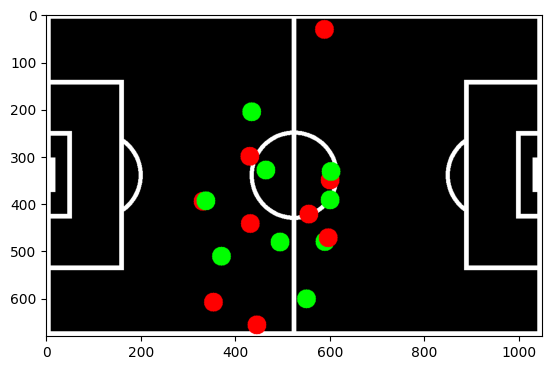

In [17]:
array_show(pitch_detector.draw_tracks_on_graphic_pitch(t, draw_ball=False)[0])

0


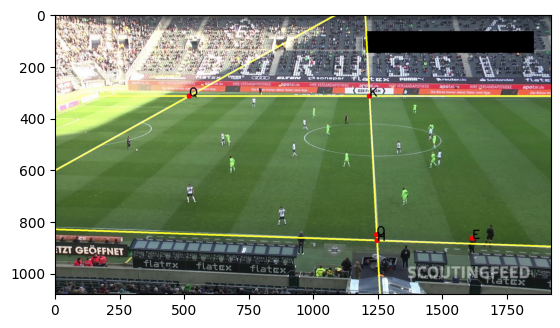

In [302]:
array_show(pitch_detector.draw_pitchs([frame])[0])

# test contour

In [111]:
Y, X, _ = frame.shape
contours = pitch_detector.get_contours(frame, pitches)
halfway_line = pitches['halfway_line']
areas = []
distance_perpendicular = []
peri = []
min_distance_perpendicular = 0
max_distance_perpendicular = X/2
min_area = 0
max_area = X/2
max_peri = X*1.5
for c in contours:
    # Obtain outer coordinates
    left, right, _, _ = pitch_detector.get_extreme_points_of_contour(c)
    d_left = pitch_detector.get_perpendicular_distance(left, halfway_line)
    d_right = pitch_detector.get_perpendicular_distance(right, halfway_line)
    d_perpendicular = (max(d_left, d_right), min(d_left, d_right))
    distance_perpendicular.append(d_perpendicular)
    areas.append(cv2.contourArea(c))
    peri.append(cv2.arcLength(c, True))

idx = [
    index for index, element in enumerate(zip(areas, distance_perpendicular, peri)) 
    if 
    element[0] >= min_area 
    and element[0] <= max_area
    and element[1][1] >= min_distance_perpendicular
    and element[1][0] <= max_distance_perpendicular
    and element[2] <= max_peri
    ]
filtered_contours = [contours[i] for i in idx ]

In [112]:
def fn(c):
    return cv2.arcLength(c, True)
cnts = sorted(filtered_contours,key=fn, reverse=True)

In [116]:
for id, c in enumerate(cnts[:10]):
    print(id, cv2.arcLength(c, True), cv2.contourArea(c))

0 2156.0773307085037 489.0
1 1992.4377219676971 97.5
2 1390.7838331460953 25.0
3 883.806129693985 4.5
4 726.5929267406464 14.0
5 722.0071401596069 9.5
6 663.7960242033005 182.5
7 543.0020874738693 172.5
8 482.02438521385193 71.0
9 475.34523379802704 71.5


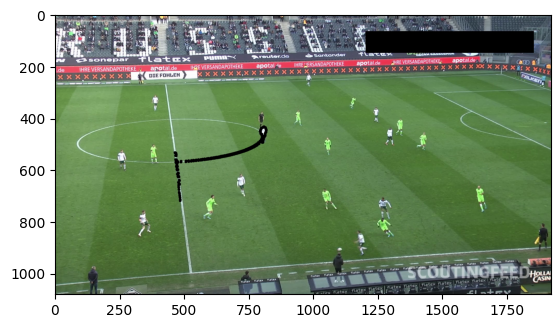

In [114]:
c_i = frame.copy()
cv2.drawContours(c_i, cnts[0], -1, 0, 10)
array_show(c_i)

0


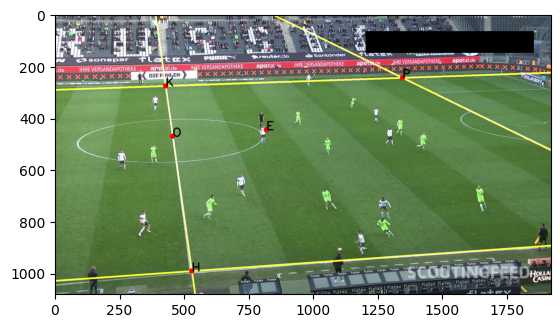

In [117]:
array_show(pitch_detector.draw_pitchs([frame])[0])

In [27]:
a[300:400]

O   H           K   M   N           P   Q           D  \
280  [742, 484]  []  [739, 318]  []  []          []  []          []   
281  [744, 504]  []  [740, 318]  []  []          []  []  [477, 504]   
282  [745, 678]  []  [738, 318]  []  []          []  []          []   
283  [737, 482]  []  [734, 318]  []  []          []  []          []   
284  [734, 498]  []  [731, 316]  []  []          []  []  [460, 498]   
285  [732, 480]  []  [729, 316]  []  []          []  []          []   
286  [728, 493]  []  [725, 316]  []  []          []  []  [451, 493]   
287  [725, 480]  []  [722, 316]  []  []          []  []          []   
288  [723, 478]  []  [720, 316]  []  []          []  []          []   
289  [719, 485]  []  [716, 314]  []  []          []  []          []   
290  [716, 476]  []  [713, 314]  []  []          []  []          []   
291  [714, 483]  []  [711, 314]  []  []          []  []          []   
292  [710, 437]  []  [708, 312]  []  []          []  []          []   
293  [708, 474]  []  [705, 312]  []  []          []  []  [420, 474]   
294  [706, 475]  []  [703, 312]  []  []          []  []          []   
295  [703, 458]  []  [700, 310]  []  []          []  []          []   
296  [700, 473]  []  [698, 310]  []  []          []  []          []   
297  [699, 462]  []  [697, 310]  []  []          []  []          []   
298  [697, 473]  []  [695, 308]  []  []          []  []  [409, 473]   
299  [696, 468]  []  [693, 308]  []  []          []  []          []   
300  [696, 473]  []  [693, 308]  []  []          []  []          []   
301  [695, 468]  []  [692, 308]  []  []          []  []          []   
302  [695, 439]  []  [693, 308]  []  []          []  []          []   
303  [698, 524]  []  [694, 308]  []  []          []  []  [673, 524]   
304  [696, 475]  []  [693, 308]  []  []          []  []          []   
305  [695, 440]  []  [693, 308]  []  []          []  []          []   
306  [698, 517]  []  [694, 308]  []  []          []  []          []   
307  [698, 520]  []  [694, 308]  []  []          []  []          []   
308  [698, 513]  []  [694, 308]  []  []          []  []          []   
309  [698, 515]  []  [694, 308]  []  []          []  []          []   
310  [698, 533]  []  [694, 308]  []  []          []  []          []   
311  [698, 517]  []  [694, 308]  []  []          []  []          []   
312  [698, 470]  []  [695, 308]  []  []          []  []          []   
313  [701, 511]  []  [697, 310]  []  []          []  []          []   
314  [699, 471]  []  [697, 308]  []  []          []  []          []   
315  [703, 425]  []  [701, 308]  []  []          []  []          []   
316  [705, 470]  []  [702, 308]  []  []          []  []          []   
317  [705, 468]  []  [702, 308]  []  []          []  []          []   
318  [705, 445]  []  [702, 308]  []  []          []  []          []   
319  [708, 470]  []  [705, 308]  []  []          []  []          []   
320  [709, 474]  []  [706, 308]  []  []          []  []          []   
321  [710, 470]  []  [707, 308]  []  []          []  []          []   
322  [712, 468]  []  [709, 308]  []  []          []  []          []   
323  [715, 489]  []  [712, 308]  []  []          []  []          []   
324  [712, 491]  []  [709, 308]  []  []          []  []          []   
325  [716, 443]  []  [714, 308]  []  []          []  []          []   
326  [719, 500]  []  [715, 308]  []  []          []  []          []   
327  [717, 472]  []  [717, 308]  []  []          []  []          []   
328  [718, 474]  []  [715, 308]  []  []          []  []          []   
329  [718, 474]  []  [716, 308]  []  []          []  []          []   
330  [718, 474]  []  [715, 308]  []  []          []  []          []   
331  [719, 496]  []  [716, 308]  []  []          []  []          []   
332  [720, 516]  []  [716, 308]  []  []          []  []          []   
333  [720, 513]  []  [716, 308]  []  []          []  []          []   
334  [719, 515]  []  [715, 308]  []  []          []  []          []   
335  [720, 546]  []  [716, 308]  []  [

# Run

In [88]:
from utils import read_video, save_video, save_video_mp4
from trackers import Tracker
import cv2
import numpy as np
from team_assigner import TeamAssigner
from player_ball_assigner import PlayerBallAssigner
from camera_movement_estimator import CameraMovementEstimator
from view_transformer import ViewTransformer
from speed_and_distance_estimator import SpeedAndDistance_Estimator
from pitch_detector import Pitch
import logging

In [51]:
cd vstats

D:\vstats


In [52]:
print(f'---Read video---')
video_name = 0
video_frames = read_video(f'input_videos/{video_name}.mp4')
# video_frames = read_video('input_videos/08fd33_4.mp4')
print(f'---Done read---')

# Initialize Tracker
tracker = Tracker('models/best.pt')

# print(len(video_frames))

tracks = tracker.get_object_tracks(video_frames,
                                    read_from_stub=True,
                                    stub_path=f'stubs/track_stubs_{video_name}.pkl')

# Interpolate Ball Positions
tracks["ball"] = tracker.interpolate_ball_positions(tracks["ball"])

# Get object positions 
tracker.add_position_to_tracks(tracks)

# camera movement estimator
camera_movement_estimator = CameraMovementEstimator(video_frames[0])
camera_movement_per_frame = camera_movement_estimator.get_camera_movement(video_frames,
                                                                            read_from_stub=True,
                                                                            stub_path=f'stubs/camera_movement_stub_{video_name}.pkl')
camera_movement_estimator.add_adjust_positions_to_tracks(tracks,camera_movement_per_frame)


# View Trasnformer
view_transformer = ViewTransformer()
view_transformer.add_transformed_position_to_tracks(tracks)


# Speed and distance estimator
speed_and_distance_estimator = SpeedAndDistance_Estimator()
speed_and_distance_estimator.add_speed_and_distance_to_tracks(tracks)

# Assign Player Teams
team_assigner = TeamAssigner()
frame_range = [0,10]
team_assigner.assign_team_color(video_frames[frame_range[0]:frame_range[1]], tracks['players'][frame_range[0]:frame_range[1]])

for frame_num, player_track in enumerate(tracks['players']):
    for player_id, track in player_track.items():
        team = team_assigner.get_player_team(video_frames[frame_num],   
                                                track['bbox'],
                                                player_id)
        tracks['players'][frame_num][player_id]['team'] = team 
        tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]



---Read video---
---Done read---


In [62]:
# Assign Ball Aquisition
player_assigner =PlayerBallAssigner()
team_ball_control= [-1]
for frame_num, player_track in enumerate(tracks['players']):
    ball_bbox = tracks['ball'][frame_num][1]['bbox']
    assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bbox)

    if assigned_player != -1:
        tracks['players'][frame_num][assigned_player]['has_ball'] = True
        team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
    else:
        if not team_ball_control:
            team_ball_control= [-1]
        else:
            team_ball_control.append(team_ball_control[-1])
team_ball_control= np.array(team_ball_control)

# Draw lines
pitch_detector = Pitch()
# print(f'---draw pitch---')
# video_frames = pitch_detector.draw_pitchs(video_frames)
# save_video_mp4(video_frames, f'output_videos/output_video_{video_name}.mp4')

# Draw output 
# Draw object Tracks
print(f'---draw tracks---')
output_video_frames = tracker.draw_annotations(video_frames, tracks,team_ball_control)
## Draw Camera movement
print(f'---draw Camera movement---')
output_video_frames = camera_movement_estimator.draw_camera_movement(output_video_frames,camera_movement_per_frame)
## Draw Speed and Distance
print(f'---draw Speed and Distance---')
speed_and_distance_estimator.draw_speed_and_distance(output_video_frames,tracks)
# # print(f'---draw graphic position---')
# output_video_frames = pitch_detector.draw_graphic_positions(tracks,output_video_frames)


---draw tracks---
---draw Camera movement---
---draw Speed and Distance---


[array([[[193, 211, 195],
         [190, 208, 192],
         [192, 213, 193],
         ...,
         [100,  92,  82],
         [103,  95,  85],
         [105,  97,  87]],
 
        [[193, 211, 195],
         [193, 211, 195],
         [197, 218, 198],
         ...,
         [105,  97,  87],
         [107,  99,  89],
         [108, 100,  90]],
 
        [[191, 213, 193],
         [195, 216, 197],
         [198, 221, 198],
         ...,
         [106,  98,  88],
         [108, 100,  90],
         [110, 102,  92]],
 
        ...,
 
        [[ 74, 103,  78],
         [ 74, 103,  78],
         [ 74, 103,  78],
         ...,
         [ 30,  47,  43],
         [ 31,  48,  44],
         [ 31,  48,  44]],
 
        [[ 74, 103,  78],
         [ 74, 103,  78],
         [ 74, 103,  78],
         ...,
         [ 44,  56,  55],
         [ 46,  58,  57],
         [ 46,  58,  57]],
 
        [[ 74, 103,  78],
         [ 74, 103,  78],
         [ 74, 103,  78],
         ...,
         [ 48,  60,  59],
  

In [63]:

# Save Video
save_video_mp4(output_video_frames, f'output_videos/output_video_{video_name}.mp4')

In [59]:
output_video_frames = pitch_detector.draw_tracks_on_graphic_pitch(tracks=tracks, scale=5, thickness=5, r=10)
save_video_mp4(output_video_frames, f'output_videos/graphic_output_video_{video_name}.mp4')

In [61]:
cv2.destroyAllWindows()

# pitch graphic

In [14]:
pitch_detector = Pitch()

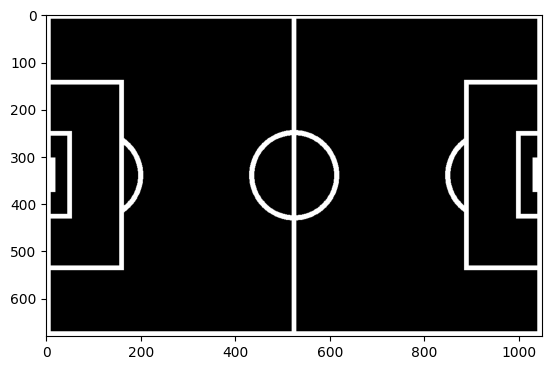

In [15]:
array_show(pitch_detector.draw_graphic_pitch(10,10))

## Tracker

In [24]:
tracker = Tracker('vstats/models/best.pt')

tracks = tracker.get_object_tracks(frames,
                                    read_from_stub=True,
                                    stub_path=f'vstats/stubs/track_stubs_{video_name}.pkl')


0: 384x640 16 players, 1 referee, 1003.1ms
1: 384x640 16 players, 2 referees, 1003.1ms
2: 384x640 12 players, 2 referees, 1003.1ms
3: 384x640 12 players, 3 referees, 1003.1ms
4: 384x640 13 players, 1 referee, 1003.1ms
5: 384x640 13 players, 1 referee, 1003.1ms
6: 384x640 13 players, 2 referees, 1003.1ms
7: 384x640 13 players, 3 referees, 1003.1ms
8: 384x640 13 players, 1 referee, 1003.1ms
9: 384x640 13 players, 1 referee, 1003.1ms
10: 384x640 13 players, 1 referee, 1003.1ms
11: 384x640 12 players, 1 referee, 1003.1ms
12: 384x640 12 players, 2 referees, 1003.1ms
13: 384x640 13 players, 3 referees, 1003.1ms
14: 384x640 11 players, 2 referees, 1003.1ms
15: 384x640 12 players, 3 referees, 1003.1ms
16: 384x640 14 players, 5 referees, 1003.1ms
17: 384x640 14 players, 2 referees, 1003.1ms
18: 384x640 15 players, 2 referees, 1003.1ms
19: 384x640 16 players, 1003.1ms
Speed: 3.3ms preprocess, 1003.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 2 ref

In [25]:
tracker.add_position_to_tracks(tracks)

## Assign Player Teams

In [26]:
test_frame = len(frames)

In [27]:
# Assign Player Teams
team_assigner = TeamAssigner()
team_assigner.assign_team_color(frames[0:10], tracks['players'][0:10])

In [28]:
for frame_num, player_track in enumerate(tracks['players']):
    for player_id, track in player_track.items():
        team = team_assigner.get_player_team(frames[frame_num], track['bbox'], player_id)
        bbox = track['bbox']
        player_color = team_assigner.get_player_color(frame=frames[frame_num], bbox=bbox)
        tracks['players'][frame_num][player_id]['team'] = team 
        tracks['players'][frame_num][player_id]['team_color'] = team_assigner.team_colors[team]
        tracks['players'][frame_num][player_id]['player_color'] = player_color
    if frame_num>test_frame:
        break

# Interpolate ball

In [29]:
tracks["ball"] = tracker.interpolate_ball_positions(tracks["ball"])

## Assign Ball Aquisition

In [30]:
player_assigner =PlayerBallAssigner()
team_ball_control= []
for frame_num, player_track in enumerate(tracks['players']):
    ball_bbox = tracks['ball'][frame_num][1]['bbox']
    assigned_player = player_assigner.assign_ball_to_player(player_track, ball_bbox)

    if assigned_player != -1:
        tracks['players'][frame_num][assigned_player]['has_ball'] = True
        team_ball_control.append(tracks['players'][frame_num][assigned_player]['team'])
    else:
        if not team_ball_control:
            team_ball_control= [-1]
        else:
            team_ball_control.append(team_ball_control[-1])
    if frame_num>test_frame:
        break
team_ball_control= np.array(team_ball_control)

In [31]:
len(team_ball_control)

200

In [32]:
# Draw output 
## Draw object Tracks
output_video_frames = tracker.draw_annotations(frames, tracks, team_ball_control)

## Draw Camera movement
# output_video_frames = camera_movement_estimator.draw_camera_movement(output_video_frames,camera_movement_per_frame)

## Draw Speed and Distance
# speed_and_distance_estimator.draw_speed_and_distance(output_video_frames,tracks)

    # Save video
save_video(output_video_frames, f'vstats/output_videos/output_video_{video_name}.avi')

In [33]:
frames[0].shape[1]

1280

# Team assignment

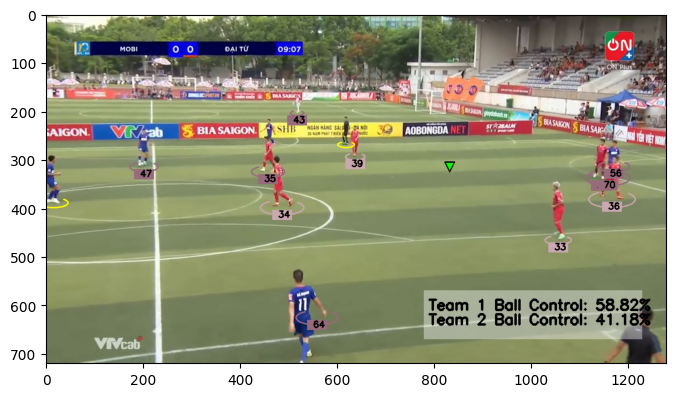

In [34]:
plt.figure(figsize = (8,8))
array_show(output_video_frames[50])

In [35]:
# why this player color wrongly clustered?

In [36]:
frame_num=50
player_id=36
frame = frames[frame_num]
bbox = tracks['players'][frame_num][player_id]['bbox']
tracks['players'][frame_num][player_id]

{'bbox': [1143.901123046875,
  297.19818115234375,
  1192.879150390625,
  382.95440673828125],
 'position': (1168, 382),
 'team': 2,
 'team_color': array([     175.28,      167.62,      201.59]),
 'player_color': array([     170.05,      161.71,      186.44])}

In [37]:
team_assigner.get_player_color(frame=frame, bbox=bbox)

array([     170.05,      161.71,      186.44])

In [ ]:
team_assigner.get_player_team(frame[50], bbox, player_id)

1

## test assignment

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

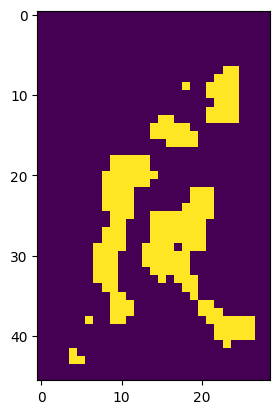

array([     189.15,      193.14,       193.4])

In [ ]:

image_path = "vstats/output_videos/cropped_image_2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Reshape the image into 2d array
top_half_image=  image[0: int(image.shape[0]/2), :]
image_2d = top_half_image.reshape(-1, 3)

# perform k-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, init="k-means++",n_init=10, random_state=1)
kmeans.fit(image_2d)

# get the cluster labels
labels = kmeans.labels_

# reshape the labels into the orginal image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

# Display the clustered image
plt.imshow(clustered_image)
plt.show()
corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
player_cluster = 1-non_player_cluster
kmeans.cluster_centers_[player_cluster]

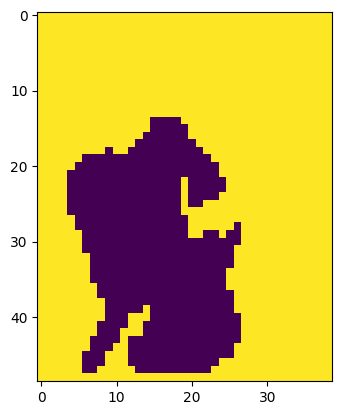

array([     95.876,      20.018,      234.26])

In [ ]:


image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
top_half_image = image[0: int(image.shape[0]/2), :]

# Get Clustering model
# Reshape the image to 2D array
image_2d = top_half_image.reshape(-1,3)

# Preform K-means with 2 clusters
kmeans = KMeans(n_clusters=2, init="k-means++",n_init=10, random_state=1)
kmeans.fit(image_2d)
# kmeans = get_clustering_model(top_half_image)

# Get the cluster labels forr each pixel
labels = kmeans.labels_

# Reshape the labels to the image shape
clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

# Get the player cluster
corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
player_cluster = 1 - non_player_cluster

player_color = kmeans.cluster_centers_[player_cluster]
# reshape the labels into the orginal image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

# Display the clustered image
plt.imshow(clustered_image)
plt.show()

corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
player_cluster = 1-non_player_cluster
kmeans.cluster_centers_[player_cluster]

In [ ]:
tracks['players'][0][player_id]

KeyError: 36

In [ ]:
X = np.vstack(team_assigner.player_colors)
centers = team_assigner.kmeans.cluster_centers_

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
pca = PCA(2)
Sc = StandardScaler()

In [ ]:

X_standard = Sc.fit_transform(X)
X_pca = pca.fit_transform(X_standard)
pca_data = pd.DataFrame(X_pca,columns=['PC1','PC2']) 
pca_data['cluster'] = pd.Categorical(team_assigner.kmeans.labels_)
pca_data['cluster'] = pd.Categorical(teams)

NameError: name 'teams' is not defined

<Axes: xlabel='PC1', ylabel='PC2'>

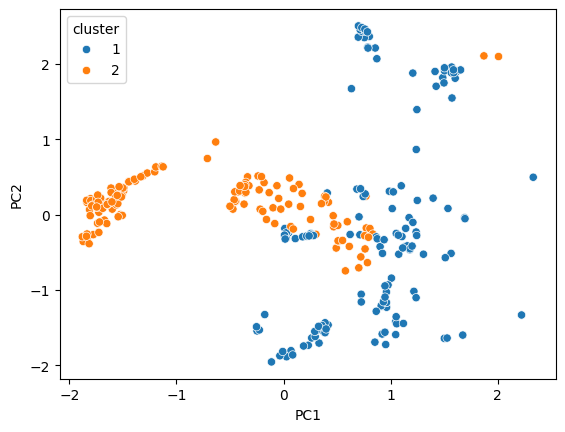

In [ ]:
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)

# Camera movement

In [8]:
frame = frames[0]

In [9]:
first_frame_grayscale = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
mask_features = np.zeros_like(first_frame_grayscale)
mask_features[:,0:144] = 1
mask_features[:,900:1050] = 1

features = dict(
    maxCorners = 100,
    qualityLevel = 0.3,
    minDistance =3,
    blockSize = 7,
    mask = mask_features
)

In [10]:
camera_movement = [[0,0]]*len(frames)

old_gray = cv2.cvtColor(frames[0],cv2.COLOR_BGR2GRAY)
old_features = cv2.goodFeaturesToTrack(old_gray,**features)

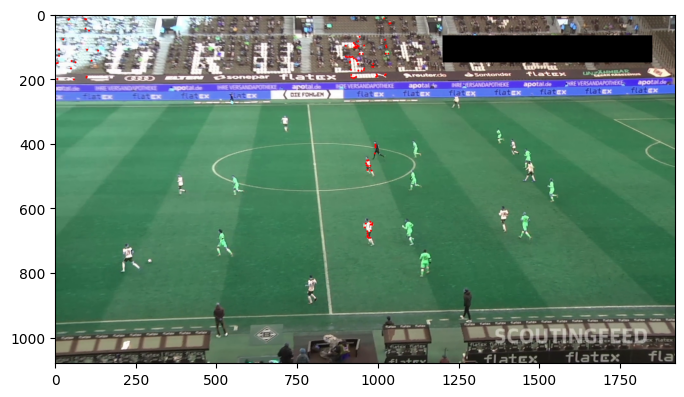

(<matplotlib.image.AxesImage at 0x25833fc4ee0>, None)

In [11]:
img = frames[100].copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
corners = cv2.goodFeaturesToTrack(gray,**features)
corners = np.int0(corners)
 
for i in corners:
 x,y = i.ravel()
 cv2.circle(img,(x,y),3,255,-1)

plt.figure(figsize = (8 ,8))
plt.imshow(img),plt.show()

In [12]:
from utils import measure_distance, measure_xy_distance
minimum_distance = 5
lk_params = dict(
            winSize = (15,15),
            maxLevel = 2,
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03)
        )

In [13]:
for frame_num in range(1,len(frames)):
    frame_gray = cv2.cvtColor(frames[frame_num],cv2.COLOR_BGR2GRAY)
    new_features, _,_ = cv2.calcOpticalFlowPyrLK(old_gray,frame_gray,old_features,None,**lk_params)

    max_distance = 0
    camera_movement_x, camera_movement_y = 0,0

    for i, (new,old) in enumerate(zip(new_features,old_features)):
        new_features_point = new.ravel()
        old_features_point = old.ravel()

        distance = measure_distance(new_features_point,old_features_point)
        if distance>max_distance:
            max_distance = distance
            camera_movement_x,camera_movement_y = measure_xy_distance(old_features_point, new_features_point ) 
    
    if max_distance > minimum_distance:
        camera_movement[frame_num] = [camera_movement_x,camera_movement_y]
        old_features = cv2.goodFeaturesToTrack(frame_gray,**features)

    old_gray = frame_gray.copy()

In [14]:
old_gray

array([[238, 238, 238, ..., 156, 132, 105],
       [198, 198, 198, ..., 130, 110,  88],
       [124, 124, 124, ...,  83,  77,  72],
       ...,
       [ 90,  89,  90, ...,  44,  47,  52],
       [ 90,  90,  90, ...,  38,  40,  46],
       [ 90,  90,  90, ...,  36,  37,  41]], dtype=uint8)

In [37]:
frame_gray = cv2.cvtColor(frames[0],cv2.COLOR_BGR2GRAY)
new_features, _,_ = cv2.calcOpticalFlowPyrLK(old_gray,frame_gray,old_features,None,**lk_params)

In [41]:
old_features.shape

(100, 1, 2)

In [28]:
camera_movement_estimator = CameraMovementEstimator(frames[0])
camera_movement_per_frame = camera_movement_estimator.get_camera_movement(frames,
                                                                            read_from_stub=False,
                                                                            stub_path='vstats/stubs/camera_movement_stub_{video_name}.pkl')

In [30]:
camera_movement_estimator.add_adjust_positions_to_tracks(tracks,camera_movement_per_frame)

In [29]:
len(camera_movement_per_frame)

750

In [27]:
len(tracks['players'])

750

# detect lines

In [291]:

# frames = [read_img_frame(15)]
video_name = 0
frames = read_video_frames(video_name)
frame = frames[79]

In [292]:
frame.shape[0]

1080

In [39]:
img = frame
# Convert to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the green range in HSV
lower_green = np.array([10, 25, 25])
upper_green = np.array([75, 255, 255])

# Create a mask for green
mask = cv2.inRange(hsv, lower_green, upper_green)

# Apply the mask to the original image
green_objects = np.zeros_like(img, np.uint8)
green_objects[mask > 0] = img[mask > 0]

In [40]:
img = green_objects.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

In [41]:
low_threshold = 25
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

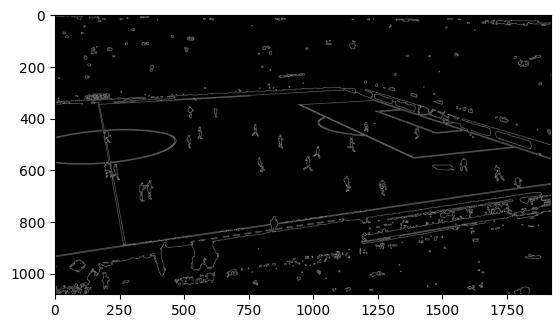

In [42]:
array_show(edges)

## detect lines

In [43]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 150  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

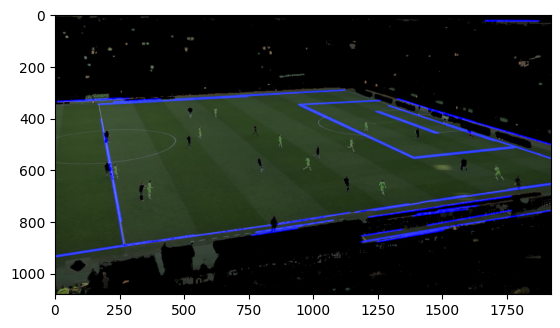

In [44]:
# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.5, line_image, 1, 0)
array_show(lines_edges)

## categorize lines based on degree

In [49]:
line_image = np.copy(img) * 0  # creating a blank to draw lines on
possible_pitches = {
    "near_horizontal_line":[],
    "far_horizontal_line":[],
    "penbox_vertical_line":[],
    "halfway_line":[]
}

for line in lines:
    for x1,y1,x2,y2 in line:
        angle_degrees = np.arctan2(abs(y1 - y2), abs(x1 - x2)) * 180 / np.pi
        if angle_degrees != 90 and angle_degrees != 0:
            # halfway line
            if 70 <= angle_degrees <= 90:
                cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),5)
                possible_pitches["halfway_line"].append(line)
            # penalty box lines
            if 15 <= angle_degrees <= 70:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,140,0),5)
                possible_pitches["penbox_vertical_line"].append(line)
            # horizontal lines
            if 0 <= angle_degrees <= 15 and min(y1,y2) >= line_image.shape[0]*0.8:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,140,150),5)
                possible_pitches["near_horizontal_line"].append(line)
            if 0 <= angle_degrees <= 15 and max(y1,y2) <= line_image.shape[0]*0.5:
                cv2.line(line_image,(x1,y1),(x2,y2),(0,140,150),5)
                possible_pitches["far_horizontal_line"].append(line)


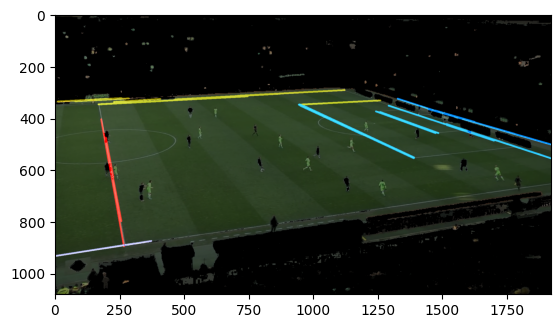

In [50]:
lines_edges = cv2.addWeighted(img, 0.5, line_image, 1, 0)
array_show(lines_edges)

## draw extended lines

In [51]:
pitches = dict.fromkeys(possible_pitches.keys(),[])
lines_detected = np.copy(img) * 0  # creating a blank to draw lines on
for line_type, filtered_lines in possible_pitches.items():
    if filtered_lines:
        X = []
        for filtered_line in filtered_lines:
            X.append(filtered_line[0][0])
        x1 = min(X, key=lambda x:abs(x-np.median(X)))
        # can return multiple lines with x1 nearest median X, get the first
        detected_line = [x for x in filtered_lines if x[0][0]==x1][0][0]
        x1,y1,x2,y2 = detected_line
        slope = (y2 - y1) / (x2 - x1)
        # 1 point with y=0 and 1 point with y = shape[0]
        cv2.line(lines_detected,(int(x2-(y2-img.shape[0])/slope),img.shape[0]),(int(x2-y2/slope),0),(0,140,150),5)
        pitches[line_type] = detected_line



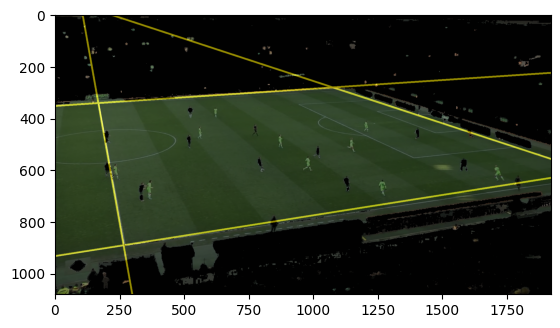

In [52]:
lines_detected_img = cv2.addWeighted(img, 0.5, lines_detected, 1, 1)
array_show(lines_detected_img)

# contours

In [44]:
video_name = 0
# frame = read_img_frame(9)
frames = read_video_frames(video_name)
frame = frames[0]
img = frame
from pitch_detector import Pitch
pitch_detector = Pitch()
contours = pitch_detector.get_contours(frame)

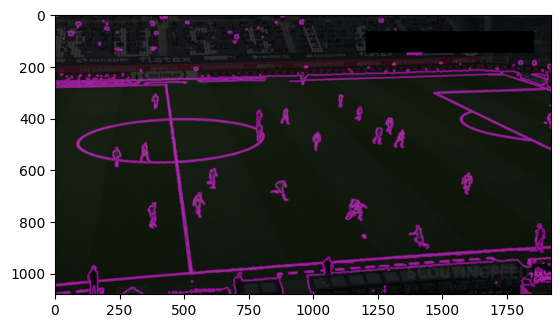

In [45]:
contour_image = np.copy(img)*0
cv2.drawContours(contour_image, contours, -1, (255, 0, 255), 5)
x = cv2.addWeighted(img, 0.2, contour_image, 0.5, 0)
array_show(x)

In [46]:
halfway_line = pitch_detector.get_pitch_lines(frame=frame)['halfway_line']
penalty_line = pitch_detector.get_pitch_lines(frame=frame)['penbox_vertical_line']
near_horizontal_line = pitch_detector.get_pitch_lines(frame=frame)['near_horizontal_line']

In [47]:
from shapely.geometry import LineString

line1 = LineString(near_horizontal_line.reshape(2,2))
line2 = LineString(halfway_line.reshape(2,2))

int_pt = line1.intersection(line2)
point_of_intersection = int_pt.x, int_pt.y

print(point_of_intersection)

(517.1972447943118, 997.9304215337735)


In [111]:
def get_center_of_line(line):
    x1,y1,x2,y2 = line[0]
    c1 = np.array([x1,y1])
    c2 = np.array([x2,y2])
    y_center = (y1+y2)/2
    x_center = (x1+x2)/2
    center = np.array([x_center,y_center], dtype=int)
    return c1, c2, center

def get_contour_distance_to_line(contour, c1, c2, center):
    left, right, _, _ = pitch_detector.get_extreme_points_of_contour(contour)
    d_left = np.linalg.norm(np.cross(c2-c1, c1-left))/np.linalg.norm(c2-c1)
    d_right = np.linalg.norm(np.cross(c2-c1, c1-right))/np.linalg.norm(c2-c1)
    # max
    d_perpendicular = max(d_left, d_right) 
    # min
    d_point = min(np.linalg.norm(center - left), np.linalg.norm(center - right))
    return d_perpendicular, d_point


In [112]:
contours = pitch_detector.get_contours(frame)
halfway_c1, halfway_c2, halfway_center = get_center_of_line(halfway_line)
penalty_c1, penalty_c2, penalty_center = get_center_of_line(penalty_line)

halfway_distances_to_center, halfway_distance_perpendicular = [], []
penalty_distances_to_center, penalty_distance_perpendicular = [], []
areas = []

halfway_features = {
    'max_distance_center': 250,
    'min_distance_perpendicular': 50,
    'max_distance_perpendicular': 500,
    'min_area': 50,
    'max_area': 500,
}
penalty_features = {
    'max_distance_center': 250,
    'min_distance_perpendicular': 50,
    'max_distance_perpendicular': 500,
    'min_area': 50,
    'max_area': 500,
}

for c in contours:
    d_perpendicular, d_point = get_contour_distance_to_line(c, halfway_c1, halfway_c2, halfway_center)
    halfway_distance_perpendicular.append(d_perpendicular)
    halfway_distances_to_center.append(d_point)

    d_perpendicular, d_point = get_contour_distance_to_line(c, penalty_c1, penalty_c2, penalty_center)
    penalty_distance_perpendicular.append(d_perpendicular)
    penalty_distances_to_center.append(d_point)

    area = cv2.contourArea(c)
    areas.append(area)

halfway_idx = [
    index for index, element in enumerate(zip(halfway_distances_to_center, areas, halfway_distance_perpendicular)) 
    if element[0] <= halfway_features['max_distance_center'] 
    and element[1] >= halfway_features['min_area'] and element[1] <= halfway_features['max_area']
    and element[2] >= halfway_features['min_distance_perpendicular'] and element[2] <= halfway_features['max_distance_perpendicular']
    ]

penalty_idx = [
    index for index, element in enumerate(zip(halfway_distances_to_center, areas, halfway_distance_perpendicular)) 
    if element[0] <= halfway_features['max_distance_center'] 
    and element[1] >= halfway_features['min_area'] and element[1] <= halfway_features['max_area']
    and element[2] >= halfway_features['min_distance_perpendicular'] and element[2] <= halfway_features['max_distance_perpendicular']
    ]

halfway_filtered_contours = [contours[i] for i in halfway_idx ]
halfway_len_contours = [len(i) for i in halfway_filtered_contours]
halfway_circle_contour = halfway_filtered_contours[halfway_len_contours.index(max(halfway_len_contours))]
halfway_circle_contour = np.vstack(halfway_filtered_contours)

penalty_filtered_contours = [contours[i] for i in penalty_idx ]
penalty_len_contours = [len(i) for i in penalty_filtered_contours]
penalty_circle_contour = penalty_filtered_contours[penalty_len_contours.index(max(penalty_len_contours))]
penalty_circle_contour = np.vstack(penalty_filtered_contours)

In [113]:
penalty_center

array([1956,  540])

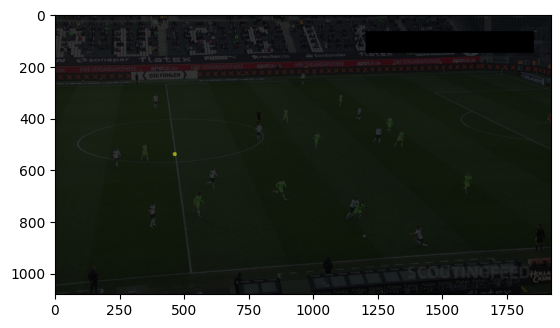

In [114]:
contour_image = np.copy(img)*0
# cv2.drawContours(contour_image, [circle_contour], -1, (255, 0, 255), 5)
cv2.circle(contour_image, halfway_center, 8, (0, 255, 255), -1)
cv2.circle(contour_image, penalty_center, 8, (0, 255, 255), -1)
x = cv2.addWeighted(img, 0.2, contour_image, 0.5, 0)
array_show(x)

In [129]:
infinity

NameError: name 'infinity' is not defined

In [34]:
from shapely.geometry import LineString, Point
line1 = LineString(np.array([[0,1,0,4]]).reshape(2,2))
line2 = LineString(np.array([[0,0,0,55]]).reshape(2,2))

int_pt = line1.intersection(line2)
point_of_intersection = int_pt.x, int_pt.y

print(point_of_intersection)

AttributeError: 'LineString' object has no attribute 'x'

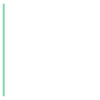

In [35]:
int_pt

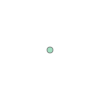

In [122]:
int_pt

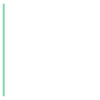

In [119]:
line1

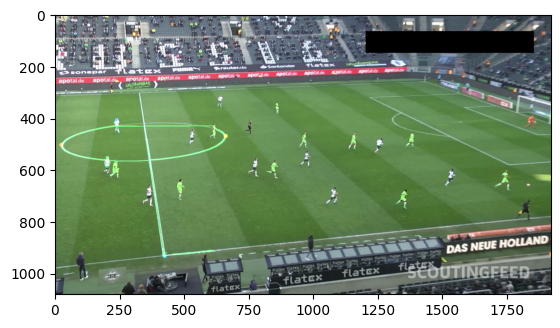

In [31]:
array_show(pitch_detector.draw_center_circle_in_frame(frame, circle_contour))

In [429]:
len_contours = [len(i) for i in contour]
contour[len_contours.index(max(len_contours))]

array([[909, 505]], dtype=int32)

In [349]:
c = get_center_circle(contours, pitches['halfway_line'])

In [350]:
# Obtain outer coordinates
left = np.array(c[c[:, :, 0].argmin()][0])
right = np.array(c[c[:, :, 0].argmax()][0])
top = np.array(c[c[:, :, 1].argmin()][0])
bottom = np.array(c[c[:, :, 1].argmax()][0])

# Draw dots onto image

print('left: {}'.format(left))
print('right: {}'.format(right))
print('top: {}'.format(top))
print('bottom: {}'.format(bottom))

left: [620 235]
right: [1353  220]
top: [1330  219]
bottom: [1128  249]


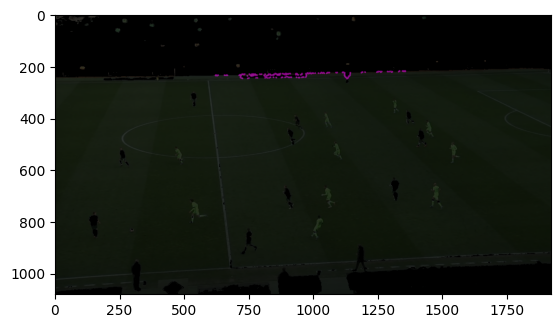

In [351]:
contour_image = np.copy(img)*0
cv2.drawContours(contour_image, c, -1, (255, 0, 255), 5)
x = cv2.addWeighted(img, 0.2, contour_image, 0.5, 0)
array_show(x)

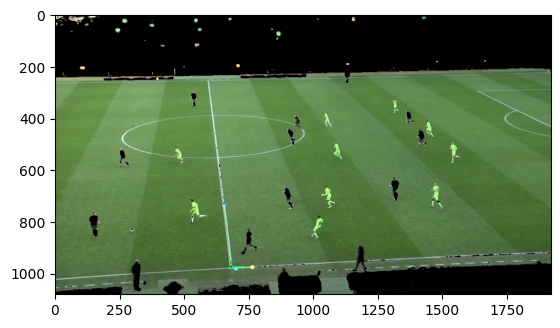

In [347]:
array_show(draw_center_circle_in_frame(frame, c))


In [108]:
pitches['halfway_line'][1]

array([ 527, 1080,  398,    0])

In [28]:
e = cv2.fitEllipse(np.vstack((*contours[200:260], *contours[256:260])))

In [268]:
# contours_i = 70
# range_elipse = (640,775)

In [269]:
# contour_image = np.copy(img)*0
# cv2.drawContours(contour_image, contours[contours_i][range_elipse[0]:range_elipse[1]], -1, (255, 0, 255), 5)
# x = cv2.addWeighted(img, 1, contour_image, 0.5, 0)
# array_show(x)

In [174]:
# e = cv2.fitEllipse(contours[contours_i][range_elipse[0]:range_elipse[1]])

In [29]:
elipse_img = lines_detected_img.copy()
# Define ellipse parameters
center_coordinates = (int(e[0][0]), int(e[0][1]))  # Center of the ellipse
axes_length = (int(e[1][1]/2), int(e[1][0]/2))     # Major and minor axes lengths
angle = 0                      # Rotation angle in degrees
start_angle = 0                # Starting angle of the elliptic arc (0 for a full ellipse)
end_angle = 360                # Ending angle of the elliptic arc (360 for a full ellipse)
color = (0, 0, 255)            # Color (BGR format)
thickness = 5                  # Thickness of the ellipse boundary

# Draw the ellipse on the image
cv2.ellipse(elipse_img, center_coordinates, axes_length, angle, start_angle, end_angle, color, thickness)
cv2.circle(elipse_img, center_coordinates, radius=5, color=(0, 0, 255), thickness=-1)

array([[[51, 74, 54],
        [47, 70, 50],
        [50, 76, 52],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[50, 74, 53],
        [50, 74, 53],
        [56, 82, 58],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[49, 76, 51],
        [54, 80, 56],
        [57, 86, 58],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[38, 52, 40],
        [38, 52, 40],
        [38, 52, 40],
        ...,
        [16, 24, 22],
        [16, 25, 23],
        [16, 25, 23]],

       [[38, 52, 40],
        [38, 52, 40],
        [38, 52, 40],
        ...,
        [23, 29, 28],
        [24, 30, 30],
        [24, 30, 30]],

       [[38, 52, 40],
        [38, 52, 40],
        [38, 52, 40],
        ...,
        [25, 31, 30],
        [26, 32, 31],
        [26, 32, 31]]], dtype=uint8)

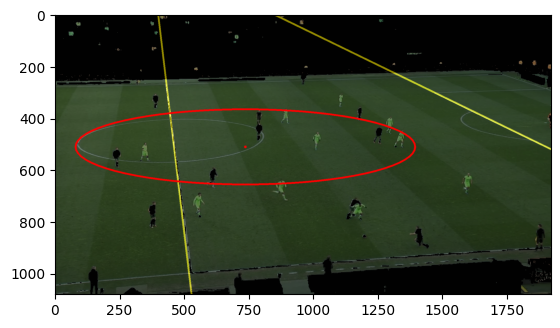

In [30]:
array_show(elipse_img)

# train

In [ ]:
# model = YOLO('vstats/models/best.pt')
model = YOLO('football_analysis/football_analysis/models/best.pt')

In [ ]:
folder_path = 'full_match_vid/annotation/Thanh Hoa/'

In [ ]:
path = f'{folder_path}{os.listdir(folder_path)[3]}'

In [ ]:
frame = cv2.imread(path)
result = model.predict(frame,conf=0.1)
im_array = result[0].plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
im.show()  # show image


0: 384x640 1 ball, 1 goalkeeper, 16 players, 2 referees, 1112.6ms
Speed: 6.0ms preprocess, 1112.6ms inference, 1080.5ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
for i in range(0,len(os.listdir(folder_path))-1):
    frame = cv2.imread(f'{folder_path}{os.listdir(folder_path)[i]}')
    result = model.predict(frame,conf=0.1)
    im_array = result[0].plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    # print (i)
    # break


0: 384x640 1 ball, 12 players, 2 referees, 1120.2ms
Speed: 3.0ms preprocess, 1120.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 10 players, 2 referees, 1649.7ms
Speed: 2.0ms preprocess, 1649.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 14 players, 3 referees, 1231.7ms
Speed: 2.0ms preprocess, 1231.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 16 players, 2 referees, 1689.9ms
Speed: 4.0ms preprocess, 1689.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 13 players, 2 referees, 1401.7ms
Speed: 2.0ms preprocess, 1401.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 19 players, 2 referees, 1487.5ms
Speed: 2.0ms preprocess, 1487.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 18 players, 1 referee,